<h1>ABHI model with Imperfect Competition</h1> 
<h3><center>Quantitative Macro Term Paper</center></h3>
<br/>


<center>Pau Belda-i-Tortosa</center> |


<center>January 2019</center>


<br/>

Code file's:

1.- TP-GE: Stationary Recursive General Equilibrium of the standard ABHI model.

2.- TP-PE: Partial Equilibrium of the ABHI model with a bargaining shock. 

3.- TP-GE-Simulation: Stationary Recursive General Equilibrium of the ABHI-CI model and simulation. 

<br/>


This is file 1.

The aggregate equilibrium (pc) wealth  is equal to 20.37
The aggregate employment is equal to 0.6269
p is equal to 1.0000
The aggregate equilibrium (pc) wealth  is equal to 21.27
The aggregate employment is equal to 0.6140
p is equal to 1.0000
The aggregate equilibrium (pc) wealth  is equal to 21.38
The aggregate employment is equal to 0.6126
p is equal to 1.0000
The aggregate equilibrium (pc) wealth  is equal to 21.39
The aggregate employment is equal to 0.6125
p is equal to 1.0000


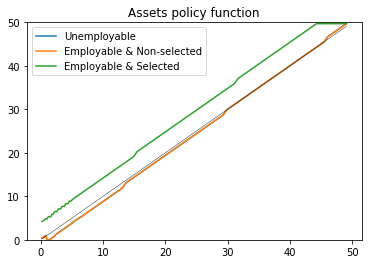

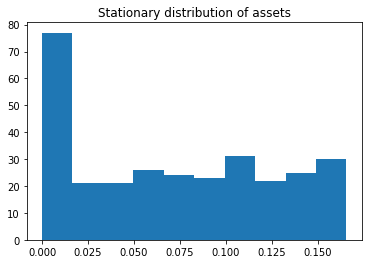

In [10]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from sympy.solvers.solveset import linsolve
import itertools as it
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from scipy.optimize import *
from numpy import *

#Parameters
Γ=0.002 #Desutility of labor size
γ=8 #Risk aversion parameter
β=0.99 #Discount factor
p=1 #Bernoulli parameter
z=1 #Productivity shock
α=0.36 #Capital share


#State space
e=[0,1]
k0=np.arange(0,5,0.2)
k1=np.arange(5.3,50,0.6)
k=np.concatenate((k0,k1))



#Transition matrix
Π= [0.85,0.15,0.1,0.9]
Π=np.reshape(Π,[2,2])

#CONVERGENCE AGGREGATE K,L
#Initial guess
L=0.96
K= 17

eps=0.001
count=0
diffK=1
diffL=1
while diffK>eps and diffL>eps:

    #STEP 0: Endogenous Prices
    w=(1-α)*z*pow((K/L),α)
    r=α*z*pow((L/K),(1-α))

    #STEP 1: Computing the utility function for all possible combinations of assets today and tomorrow
    #Retrieving the Consumption Matrix using a non-linear solver
    C=np.empty((100,100,2))
    for i,I,j in it.product(range(100), range(100),range(2)):
        def Implicit(x):
            e=[0,1]
            k=np.concatenate((k0,k1))
            c=x[0]
            F=empty((1))
            F[0] = pow(w*e[j], ((1+γ)/γ))*pow(Γ*c, -1/γ) + ((1+r)*k[i]) - k[I] -c
            return F
        C[i,I,j]=fsolve(Implicit,1)

    #Utility for consumption 
    logC= np.log(C)
    #Computing disutility from labour
    #U_L=np.zeros((100,100,2)) 
    U_L = (Γ/(1+γ))*pow((w/Γ*C), ((1+γ)/γ))
    #Total Utility 
    U= logC - U_L

    #STEP 2: Initial Guess 
    #Define initial functions 
    V00=np.zeros((100,1))
    V10=np.zeros((100,1))
    V11=np.zeros((100,1))
    G00=np.zeros((100,1))
    G10=np.zeros((100,1))
    G11=np.zeros((100,1))


    #STEP 3: Value Function Iteration
    V00t=np.zeros((100,1))
    V10t=np.zeros((100,1))
    V11t=np.zeros((100,1))

    count = 0
    eps=0.001
    Dev=0.5
    while Dev > eps: 
        for i in range(99):
            V00t[i]= max(U[i,:,0] + β*((Π[0,0]*V00[i])+ (Π[0,1]*V10[i]*(1-p))+(Π[0,1]*V11[i]*p)))       
            V10t[i] = max(U[i,:,0] + β*((Π[1,0]*V00[i])+(Π[1,1]*V10[i]*(1-p))+(Π[1,1]*V11[i]*p)))
            V11t[i] = max(U[i,:,1]+ β*((Π[1,0]*V00[i])+(Π[1,1]*V10[i]*(1-p))+(Π[1,1]*V11[i]*p)))
            G00[i] = np.argmax(U[i,:,0] + β*((Π[0,0]*V00[i])+ (Π[0,1]*V10[i]*(1-p))+(Π[0,1]*V11[i]*p)))
            G10[i] = np.argmax(U[i,:,0] + β*((Π[1,0]*V00[i])+(Π[1,1]*V10[i]*(1-p))+(Π[1,1]*V11[i]*p)))
            G11[i] = np.argmax(U[i,:,1]+ β*((Π[1,0]*V00[i])+(Π[1,1]*V10[i]*(1-p))+(Π[1,1]*V11[i]*p)))

        #Check the difference
        Diff0=abs(V00t-V00)
        dev00=Diff0.max()
        Diff10=abs(V10t-V10)
        dev10=Diff10.max()
        Diff11=abs(V11t-V11)
        dev11=Diff11.max()
        Dev=max(dev00, dev10, dev11)
       
        #Update
        V00=V00t
        V10=V10t 
        V11=V11t
        count+=1

    #STEP 4: Policy functions
    g00=np.zeros((100,1))
    g10=np.zeros((100,1))
    g11=np.zeros((100,1))

    for i in range(100):
        g00[i]=k[int(G00[i])]
        g10[i]=k[int(G10[i])]
        g11[i]=k[int(G11[i])]

    
    #STEP 5: Aggregation. We have 300 different social positions. 
    assets=np.vstack((g00,g10,g11))
    A=sum(assets)/300

    #STEP 6: INVARIANT DISTRIBUTION
    #Measure over assets
    #Matrix I: assets transition
    k=np.concatenate((k0,k1))
    grid=np.hstack((k,k,k))
    I=np.empty((300,300))
    for i,j in it.product(range(300),range(300)):
        I[i,j]= int(grid[i]==assets[j])

    #Matrix Pi: employment transition
    π00_00=np.ones(100)*0.85
    π00_10=np.ones(100)*0.15*(1-p)
    π00_11=np.ones(100)*0.15*p
    π10_00=np.ones(100)*0.1
    π10_10=np.ones(100)*0.9*(1-p)
    π10_11=np.ones(100)*0.9*p
    π11_00=np.ones(100)*0.1
    π11_10=np.ones(100)*0.9*(1-p)
    π11_11=np.ones(100)*0.9*p

    π00=np.transpose(np.concatenate((π00_00,π00_10,π00_11), axis=0))
    π10=np.transpose(np.concatenate((π10_00,π10_10,π10_11), axis=0))
    π11=np.transpose(np.concatenate((π11_00,π11_10,π11_11), axis=0))
    π00=np.tile(π00,(100,1))
    π10=np.tile(π10,(100,1))
    π11=np.tile(π11,(100,1))
    π=np.vstack((π00,π10,π11))

    #Matrix T: state transition
    T=np.multiply(π,I)

    #Vector M: distribution guess
    M=np.ones((300,1))*(1/300)

    #Invariant distribution
    eps=0.001
    diff=1
    count=0
    while diff>eps:
        Distribution=T@M
        diff=(Distribution-M).all()
        count+=1
        M=Distribution

    np.sum(Distribution)

    #Aggregate savings
    S=Distribution*assets
    print('The aggregate equilibrium (pc) wealth  is equal to '"{0:.2f}".format(np.sum(S)))

    #STEP 7: Aggregate labour
    S00=S[0:100]
    S10=S[100:200]
    S11=S[200:300]
    #First, recover the optimal consumption vector
    C00=np.empty((100,1))
    C10=np.empty((100,1))
    C11=np.empty((100,1))
    for i,I in it.product(range(100), range(100)):
        def Ramsey(x):
            c=x[0]
            F=empty((1))
            F[0] = (1+r)*S00[i] - S00[I] -c
            return F

        C00[i]=fsolve(Ramsey,1)
        
    for i,I in it.product(range(100), range(100)):
        def Ramsey(x):
            c=x[0]
            F=empty((1))
            F[0] = (1+r)*S10[i] - S10[I] -c
            return F

        C10[i]=fsolve(Ramsey,1)

    for i,I in it.product(range(100), range(100)):
        def Ramsey(x):
            c=x[0]
            F=empty((1))
            F[0] = pow(w, (1+γ/γ))*pow(Γ*c, -1/γ) + (1+r)*S11[i] - S11[I] -c
            return F

        C11[i]=fsolve(Ramsey,1)

    #Recover the optimal labour vector
    N00=np.zeros((100,1))
    N10=np.zeros((100,1))
    N11=np.empty((100,1))
    for j in range(100):
        N11[j] = pow(((w*e[1])/(Γ*C11[j])), 1/γ)

    E=np.concatenate((N00,N10,N11))
    Employment=Distribution*E
    print('The aggregate employment is equal to '"{0:.4f}".format(np.sum(Employment)))
    
    Employables_Non=Distribution[100:300]*(1-p)
    p=np.sum(Employment)/(np.sum(Employables_Non)+np.sum(Employment)) # (Employables-Employees)/Employables
    
    print('p is equal to '"{0:.4f}".format(p))
    #STEP 8: Check & update
    #Check the difference
    diffK=abs(np.sum(S)-K)
    diffL=abs(np.sum(Employment)-L)
    
    #Update the guess
    count+=1
    L=np.sum(Employment)
    K=np.sum(S)

#PLOT THE FINAL POLICY AND DISTRIBUTION
plt.plot(k[1:99],g00[1:99], label='Unemployable')
plt.plot(k[1:99],g10[1:99], label='Employable & Non-selected')
plt.plot(k[1:99],g11[1:99], label='Employable & Selected')
plt.plot(k[1:99],k[1:99], 'k', linewidth=0.4)
plt.legend()
plt.ylim([0,50])
plt.title('Assets policy function')
plt.show()      


plt.hist(S)
plt.title('Stationary distribution of assets')
plt.show()

In [18]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

print('Wealth Gini coefficient:'"{0:.4f}".format(gini(S)))

Wealth Gini coefficient:0.4398


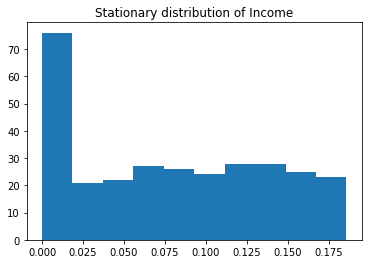

Income Gini coefficient:0.4333
Labor Income Gini coefficient:0.7776
Capital Income Gini coefficient:0.4398


In [19]:
Labor_Income=Employment*w
Capital_Income=S*(1+r)
Income=Labor_Income + Capital_Income
plt.hist(Income)
plt.title('Stationary distribution of Income')
plt.show()
print('Income Gini coefficient:'"{0:.4f}".format(gini(Income)))
print('Labor Income Gini coefficient:'"{0:.4f}".format(gini(Labor_Income)))
print('Capital Income Gini coefficient:'"{0:.4f}".format(gini(Capital_Income)))

In [24]:
LS=w*L/(w*L+r*K)
GDP=((w*L)+(r*K))
print('LS is equal to '"{0:.4f}".format(LS))
print('GDP is equal to '"{0:.4f}".format(GDP))

LS is equal to 0.6398
GDP is equal to 2.2011
